## Predicting the steps transition II

This was another attempt at the prediction of the steps using the **variance and autocorrelation** features.

This one has **interesting visualization insights** (see below). We try to catch increases in variance or autocorrelation before the step occurs.

##### Debug mode

In [1]:
%load_ext autoreload
%autoreload 2

##### For relative imports

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

##### Notebook

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import mpld3
from interval import Interval
from observation import Observation
from constants import *
from datetime import timedelta
from tools import sequence_to_interval
plt.style.use('ggplot')
mpld3.enable_notebook()

reactor_site = "B1" #[site+tranche for site in ["A","B","C","D","E","F","G","H"] for tranche in ["1","2"]] + ["B3","B4","F3","F4"]

suffixes = [
"DEB1-1"
] 

PATH = "../../Data/GMPP_IRSDI/"
obs = Observation(PATH,reactor_site,suffixes,verbose=1,ignore_keys=deb2)

print(str(len(obs.df))+" : Initial length of full df")
print(str(len(obs.full_concatenated_df))+" : New length of all selected intervals")

Loading in memory 1 observations...
Concatenation...
Changing isolated wrong values...
Forward Filling...
Backward Filling...
525887 : Initial length of full df
504474 : New length of all selected intervals


### Defining Dataframe wrapper and highlight function

In [4]:
class MyDataFrame(object):
    def __init__(self, df):
        self.df = df
        self.list_df = [df]
        self.n_updates = 0
    def update(self,df):
        self.df = df
        self.list_df+=[df]
        self.n_updates += 1
    def last_indices_removed(self):
        return self.list_df[-2].index.difference(self.list_df[-1].index)
    def __str__(self):            
        return str(len(self.df))  if (len(self.df)<=999) else ">999"

# Style should be an attribute of the dataframe
    
def highlight_not_null(df_colors=['green'], null_color='red',unknown_color='white'):
    def style_function(s):
        colors = []
        for p in s: 
            if pd.isnull(p):
                colors+=[null_color]
            elif type(p) is MyDataFrame:
                colors+=[df_colors[p.n_updates]]
            else:
                colors+=[unknown_color]
        return ['background-color: '+color for color in colors]
    return style_function

### Get scores

In [125]:
with open('/home/mehlman/Data/scores_kept_df.pkl', 'rb') as input:
    scores_kept_df = pickle.load(input)
colors_scores_kept = ["#3afffb","#1ecebc","#25ed75","#26ad5c","#26ad5c","#26ad5c"]
scores_kept_df.style.apply(highlight_not_null(colors_scores_kept))

,10m,3h,6h,1d,7d,30d,180d
trend_up,nan,nan,nan,91,12,4,1
trend_down,nan,nan,nan,44,9,2,4
step,nan,nan,146,8,5,nan,nan
spike,32,nan,nan,nan,nan,nan,nan
oscillation,nan,10,nan,nan,nan,nan,nan


### Observe all intervals with steps

In [75]:
from interval import Interval

length_of_interest = timedelta(days = 2)
step_indices = scores_kept_df.loc["step","6h"].df.index.tolist()
intervals_step = Interval(step_indices, timedelta(hours = 10)).intervals
intervals_before = Interval(step_indices, timedelta(hours = 0)).before(length_of_interest)

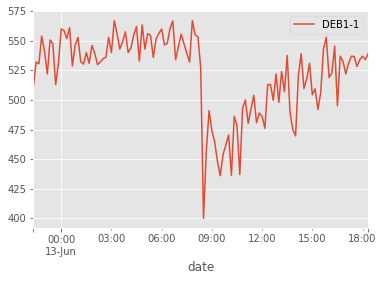

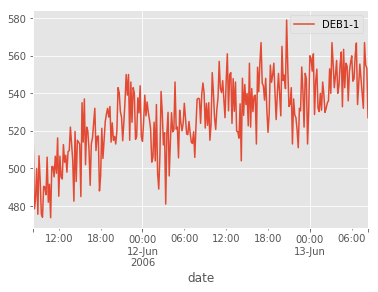

In [76]:
index = 6
begin_step, end_step = intervals_step[index]
obs.full_concatenated_df[begin_step:end_step].plot()
begin_study, end_study = intervals_before[index]
obs.full_concatenated_df[begin_study:end_study].plot()

### Observe corresponding variance - autocorrelation before

In [77]:
from exploitation.potential import sliding_variance, sliding_autocovariance

sliding_window_timedelta = length_of_interest/2
sliding_window_units = int(sliding_window_timedelta/ timedelta(minutes=10))

series_of_study = obs.full_concatenated_df[begin_study:end_study]
series_of_study_values = series_of_study.values.ravel()
sv = sliding_variance(series_of_study_values,sliding_window_units)
sa = sliding_autocovariance(series_of_study_values,sliding_window_units,1,True)
series_of_study = series_of_study.assign(sa = sa, sv = sv)

### Analysis of variance and autocorrelation

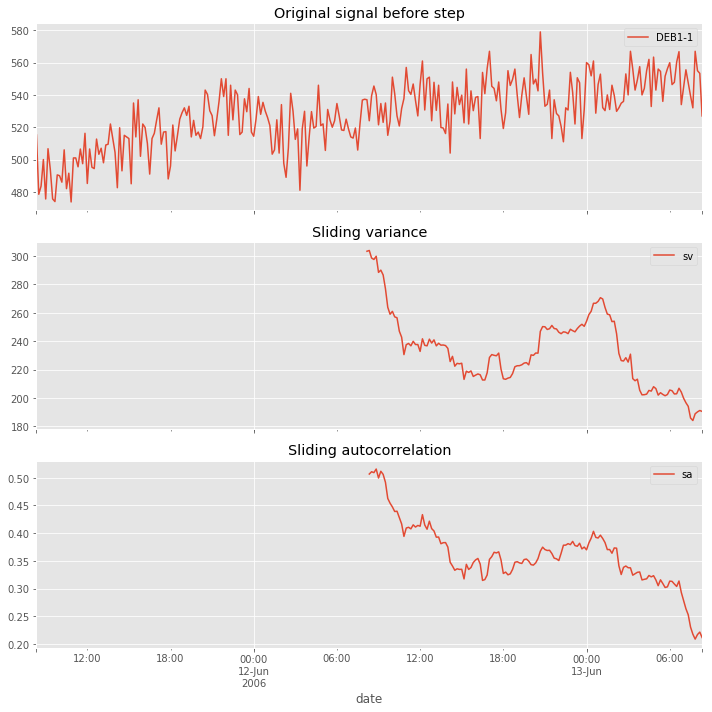

In [78]:
fig, axes = plt.subplots(3,sharex = True, figsize=(10,10))
series_of_study[[deb1[0]]].plot(ax = axes[0],title="Original signal before step")
series_of_study[["sv"]].plot(ax = axes[1],title="Sliding variance")
series_of_study[["sa"]].plot(ax = axes[2],title="Sliding autocorrelation")
plt.tight_layout()

### Visualizing everything at once

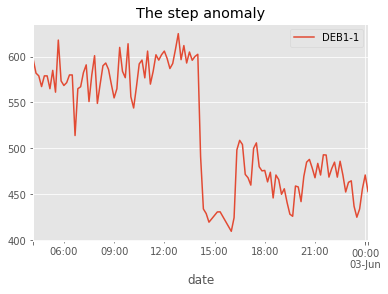

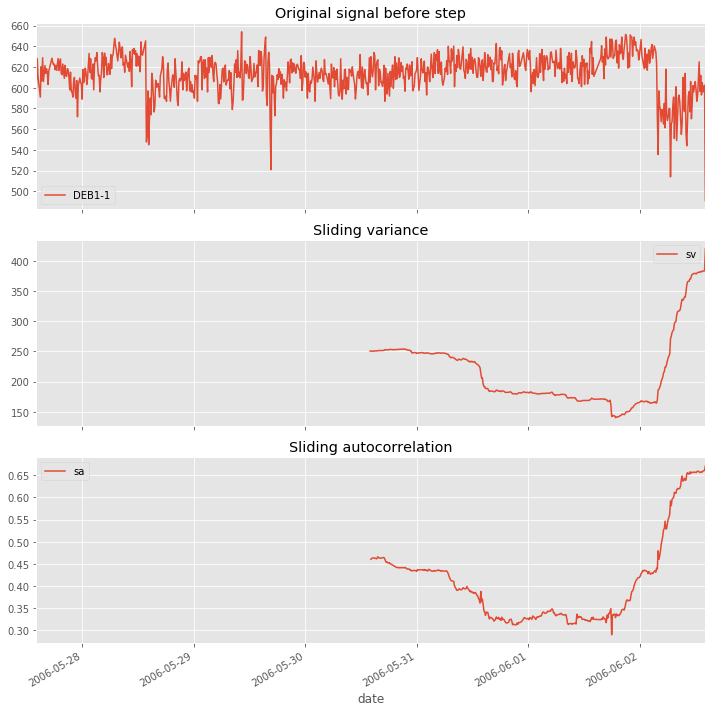

In [134]:
from interval import Interval

length_of_interest = timedelta(days = 6)
step_indices = scores_kept_df.loc["step","6h"].df.index.tolist()
intervals_step = Interval(step_indices, timedelta(hours = 10)).intervals
intervals_before = Interval(step_indices, timedelta(hours = 0)).before(length_of_interest)

index = 3
begin_step, end_step = intervals_step[index]
obs.full_concatenated_df[begin_step:end_step].plot(title="The step anomaly")
begin_study, end_study = intervals_before[index]
series_of_study = obs.full_concatenated_df[begin_study:end_study]

sliding_window_timedelta = length_of_interest/2
sliding_window_units = int(sliding_window_timedelta/ timedelta(minutes=10))

series_of_study_values = series_of_study.values.ravel()
sv = sliding_variance(series_of_study_values,sliding_window_units)
sa = sliding_autocovariance(series_of_study_values,sliding_window_units,1,True)
series_of_study = series_of_study.assign(sa = sa, sv = sv)

fig, axes = plt.subplots(3,sharex = True, figsize=(10,10))
series_of_study[[deb1[0]]].plot(ax = axes[0],title="Original signal before step")
series_of_study[["sv"]].plot(ax = axes[1],title="Sliding variance")
series_of_study[["sa"]].plot(ax = axes[2],title="Sliding autocorrelation")
plt.tight_layout()

In [135]:
from exploitation.mk_test import mk_test
mk_test(series_of_study[["sa"]].dropna().values.ravel())

('no trend', False, 0.31379385694102235, -1.0072932825126708)

<hr style="height:3px">

## Running the statistical approach for everything at once !

In [150]:
class Stats(object):
    def __init__(self):
        self.dict_scores = {'decreasing':0,
                            'increasing':0,
                            'no trend':0}
    def update(self,mk_results):
        self.dict_scores[mk_results[0]]+=1

    def __str__(self):            
        return str(self.dict_scores['increasing'])+','+\
                str(self.dict_scores['no trend'])+','+\
                str(self.dict_scores['decreasing'])
    
length_tag = ["1d","2d","3d","4d"]
features = ["variance","autocorrelation"]
stats_df = pd.DataFrame(index=features,columns=length_tag,dtype=np.float64)
for f in features:
    for tag in length_tag:
        stats_df.loc[f,tag] = Stats()
stats_df        

,1d,2d,3d,4d
variance,"0,0,0","0,0,0","0,0,0","0,0,0"
autocorrelation,"0,0,0","0,0,0","0,0,0","0,0,0"


In [151]:
for begin_study, end_study in intervals_before[:30]:
    for tag_length, length_of_interest in zip(length_tag,[timedelta(days = t) for t in [2,4,6,8]]):
        sliding_window_timedelta = length_of_interest/2
        sliding_window_units = int(sliding_window_timedelta/ timedelta(minutes=10))
        
        series_of_study = obs.full_concatenated_df[begin_study:end_study]
        series_of_study_values = series_of_study.values.ravel()
        sv = sliding_variance(series_of_study_values,sliding_window_units)
        sa = sliding_autocovariance(series_of_study_values,sliding_window_units,1,True)
        series_of_study = series_of_study.assign(sa = sa, sv = sv)
        stats_df.loc["variance",tag_length].update(mk_test(series_of_study[["sv"]].dropna().values.ravel()))
        stats_df.loc["autocorrelation",tag_length].update(mk_test(series_of_study[["sa"]].dropna().values.ravel()))

In [152]:
stats_df

,1d,2d,3d,4d
variance,"16,3,11","16,1,13","13,4,13","15,3,12"
autocorrelation,"10,5,15","15,5,10","12,5,13","14,1,15"
